In [1]:
import mne
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import joblib
from scipy.signal import welch

# Data direction
data_dir = 'data'

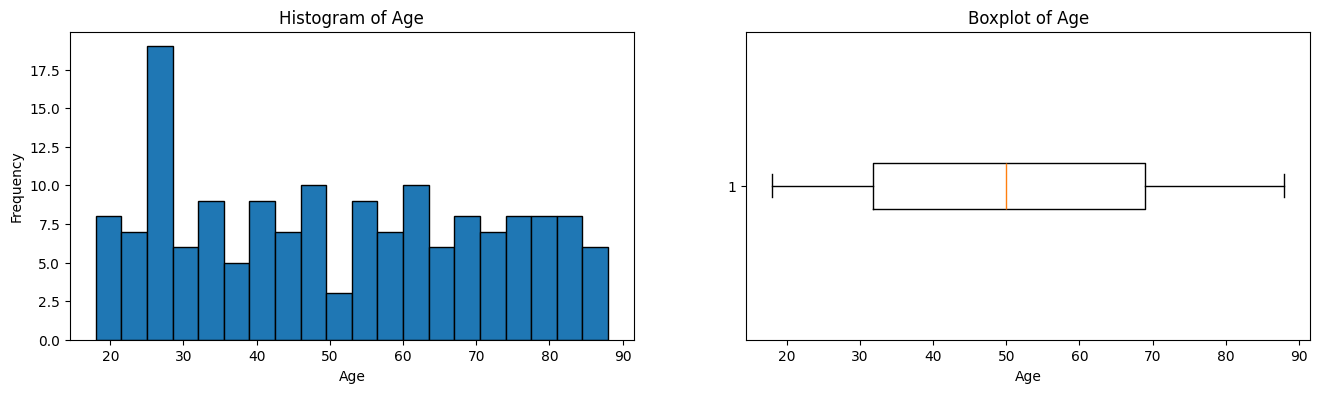

In [2]:
# Visualize Age Distribution
labels_df = pd.read_csv(os.path.join(data_dir,'label.tsv'), sep='\t')

plt.figure(figsize=(16, 4))
# Histogram
plt.subplot(1,2,1)
plt.hist(labels_df['age'], bins=20, edgecolor='black')
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
# Boxplot
plt.subplot(1,2,2)
plt.boxplot(labels_df['age'], vert=False)
plt.title('Boxplot of Age')
plt.xlabel('Age')
plt.show()

In [3]:
# Rename participant_id to subject
labels_df = labels_df.rename(columns={'participant_id':'subject'})

# Remove 'sub-' prefix from subject column
labels_df['subject'] = labels_df['subject'].str.replace('sub-', '', regex=False)

# Checking
print(labels_df)

      subject  age
0    CC110033   24
1    CC110037   18
2    CC110045   24
3    CC110056   22
4    CC110069   28
..        ...  ...
155  CC721704   82
156  CC721891   83
157  CC721894   80
158  CC722542   79
159  CC723395   86

[160 rows x 2 columns]


In [4]:
# Function to extract PSD features
def extract_psd_features(data, sfreq, n_fft=2048, n_overlap=1024, low_freq=1, high_freq=75, feature_dim=200):
  if len(data) < n_fft:
    nperseg = len(data)
    noverlap = nperseg//2
  else:
    nperseg = n_fft
    noverlap = n_overlap

  psds, freqs = welch(data, sfreq, nperseg=nperseg, noverlap=noverlap, axis=0, return_onesided=True)
  # Use only a limited range of frequencies to reduce feature dimensions
  freq_mask = (freqs >= low_freq) & (freqs <= high_freq)
  
  if np.any(freq_mask):
        psds = psds[freq_mask]
  else:
        psds = np.zeros(0)
  
  if psds.shape[0] > feature_dim:
     psds = psds[:feature_dim]
  elif psds.shape[0] < feature_dim:
      pad_size = feature_dim - psds.shape[0]
      psds = np.pad(psds, (0, pad_size), 'constant')

  return psds

# Function to extract DE features
def extract_de_features(data, sfreq, n_fft=2048, n_overlap=1024, low_freq=1, high_freq=75, feature_dim=200):
  
  if len(data) < n_fft:
    nperseg = len(data)
    noverlap = nperseg//2
  else:
    nperseg = n_fft
    noverlap = n_overlap

  psds, freqs = welch(data, sfreq, nperseg=nperseg, noverlap=noverlap, axis=0, return_onesided=True)
  # Use only a limited range of frequencies to reduce feature dimensions
  freq_mask = (freqs >= low_freq) & (freqs <= high_freq)
  
  if np.any(freq_mask):
        psds = psds[freq_mask]
  else:
        psds = np.zeros(0)
  
  if psds.shape[0] > feature_dim:
     psds = psds[:feature_dim]
  elif psds.shape[0] < feature_dim:
      pad_size = feature_dim - psds.shape[0]
      psds = np.pad(psds, (0, pad_size), 'constant')

  # Replace 0 values by very small values before log
  psds[psds == 0] = 1e-10

  de = np.log1p(psds) # Natural logarithm
  return de

# Function to load EEG data and extract features
def load_eeg_data_and_extract_features(file_path, feature_type="PSD", feature_dim=200):
    raw = mne.io.read_raw_fif(file_path, preload=True)
    misc_channels = raw.copy().pick_types(misc=True)
    data = misc_channels.get_data()
    sfreq = raw.info['sfreq']

    all_channel_features = []
    for channel_data in data:
        if feature_type == "PSD":
            features = extract_psd_features(channel_data, sfreq, feature_dim=feature_dim)
        elif feature_type == "DE":
            features = extract_de_features(channel_data, sfreq, feature_dim=feature_dim)
        else:
            raise ValueError("Invalid feature_type. Choose either 'PSD' or 'DE'.")
        all_channel_features.append(features)

    return np.array(all_channel_features).flatten()

# Function to get the subject ID from file name
def get_subject_id(file_name):
    return file_name.split('-')[1].split('_')[0]

# Function to calculate frequency count in a specific frequency range
def calculate_frequency_count(data, sfreq, n_fft=2048, n_overlap=1024, low_freq=1, high_freq=50):
    # Correct overlap if data is too short
    if len(data) < n_fft:
        nperseg = len(data)
        noverlap = nperseg//2 # or any value smaller than nperseg
    else:
        nperseg = n_fft
        noverlap = n_overlap
    freqs, psd = welch(data, sfreq, nperseg=nperseg, noverlap=noverlap, axis=0, return_onesided=True)
    freq_mask = (freqs >= low_freq) & (freqs <= high_freq)
    return np.sum(freq_mask)


In [5]:
low_freq = 1
high_freq = 75

channel_data = np.random.rand(1000)
freq_count = calculate_frequency_count(channel_data, sfreq = 250, n_fft = 2048, n_overlap = 1024, low_freq = 1, high_freq = 75)

print(f"Number of frequencies in the range {low_freq}-{high_freq} Hz: {freq_count}")

Number of frequencies in the range 1-75 Hz: 297


In [6]:
# Load all data
all_features_psd = []
all_features_de = []
all_subjects = []
for filename in os.listdir(data_dir):
    if filename.endswith('.fif'):
        file_path = os.path.join(data_dir, filename)
        features_psd = load_eeg_data_and_extract_features(file_path, feature_type="PSD", feature_dim=300)
        features_de = load_eeg_data_and_extract_features(file_path, feature_type="DE", feature_dim=300)
        subject_id = get_subject_id(filename)
        all_features_psd.append(features_psd)
        all_features_de.append(features_de)
        all_subjects.append(subject_id)

all_features_psd = np.array(all_features_psd)
all_features_de = np.array(all_features_de)
all_subjects = np.array(all_subjects)

# Convert into df
features_df_psd = pd.DataFrame({'subject': all_subjects, 'features': list(all_features_psd)})
features_df_de = pd.DataFrame({'subject': all_subjects, 'features': list(all_features_de)})

print("features_df_psd head:")
print(features_df_psd.head())
print("features_df_de head:")
print(features_df_de.head())

# Merge with labels dataframe
merged_df_psd = pd.merge(features_df_psd, labels_df, on='subject')
merged_df_de = pd.merge(features_df_de, labels_df, on='subject')

Opening raw data file data/sub-CC221511_sflip_parc-raw.fif...
    Range : 18250 ... 159499 =     73.000 ...   637.996 secs
Ready.
Reading 0 ... 141249  =      0.000 ...   564.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Opening raw data file data/sub-CC221511_sflip_parc-raw.fif...
    Range : 18250 ... 159499 =     73.000 ...   637.996 secs
Ready.
Reading 0 ... 141249  =      0.000 ...   564.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Opening raw data file data/sub-CC723395_sflip_parc-raw.fif...
    Range : 4000 ... 143999 =     16.000 ...   575.996 secs
Ready.
Reading 0 ... 139999  =      0.000 ...   559.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Opening raw data file data/sub-CC723395_sflip_parc-raw.fif...
    Range : 4000 ... 143999 =     16.000 ...   575.996 secs
Ready.
Reading 0 ... 139999  =      0.000 ...   559.996 secs...
NOTE: pick_types() is a

In [7]:
# Prepare train and test dataset for PSD
subjects_psd = merged_df_psd['subject'].tolist()
labels_psd = merged_df_psd['age'].tolist()
features_psd = np.array(merged_df_psd['features'].tolist())

# Randomly select 40 subjects for testing (PSD)
np.random.seed(42)
test_size = 40
test_indices_psd = np.random.choice(len(subjects_psd), test_size, replace=False)

train_indices_psd = [i for i in range(len(subjects_psd)) if i not in test_indices_psd]

X_train_psd = features_psd[train_indices_psd]
y_train_psd = np.array(labels_psd)[train_indices_psd]
X_test_psd = features_psd[test_indices_psd]
y_test_psd = np.array(labels_psd)[test_indices_psd]

# Shape chec k
print("Shape of X_train:", X_train_psd.shape)
print("Shape of y_train:", y_train_psd.shape)
print("Shape of X_test:", X_test_psd.shape)
print("Shape of y_test:", y_test_psd.shape)

Shape of X_train: (120, 15600)
Shape of y_train: (120,)
Shape of X_test: (40, 15600)
Shape of y_test: (40,)


In [8]:
# Prepare train and test dataset for DE
subjects_de = merged_df_de['subject'].tolist()
labels_de = merged_df_de['age'].tolist()
features_de = np.array(merged_df_de['features'].tolist())

# Randomly select 40 subjects for testing (DE)
np.random.seed(42)
test_size = 40
test_indices_de = np.random.choice(len(subjects_de), test_size, replace=False)

train_indices_de = [i for i in range(len(subjects_de)) if i not in test_indices_de]

X_train_de = features_de[train_indices_de]
y_train_de = np.array(labels_de)[train_indices_de]
X_test_de = features_de[test_indices_de]
y_test_de = np.array(labels_de)[test_indices_de]

# Shape checking
print("Shape of X_train:", X_train_de.shape)
print("Shape of y_train:", y_train_de.shape)
print("Shape of X_test:", X_test_de.shape)
print("Shape of y_test:", y_test_de.shape)

Shape of X_train: (120, 15600)
Shape of y_train: (120,)
Shape of X_test: (40, 15600)
Shape of y_test: (40,)


In [9]:
# Scale the features for PSD
scaler_psd = StandardScaler()
X_train_scaled_psd = scaler_psd.fit_transform(X_train_psd)
X_test_scaled_psd = scaler_psd.transform(X_test_psd)

# Scale the features for DE
scaler_de = StandardScaler()
X_train_scaled_de = scaler_de.fit_transform(X_train_de)
X_test_scaled_de = scaler_de.transform(X_test_de)

In [10]:
from sklearn.decomposition import PCA

# Apply PCA for PSD
pca_psd = PCA(n_components=0.99)
X_train_pca_psd = pca_psd.fit_transform(X_train_scaled_psd)
X_test_pca_psd = pca_psd.transform(X_test_scaled_psd)

print("PSD PCA Train set shape", X_train_pca_psd.shape)
print("PSD PCA Test set shape", X_test_pca_psd.shape)

# Apply PCA for DE
pca_de = PCA(n_components=0.99)
X_train_pca_de = pca_de.fit_transform(X_train_scaled_de)
X_test_pca_de = pca_de.transform(X_test_scaled_de)

print("DE PCA Train set shape", X_train_pca_de.shape)
print("DE PCA Test set shape", X_test_pca_de.shape)

PSD PCA Train set shape (120, 97)
PSD PCA Test set shape (40, 97)
DE PCA Train set shape (120, 99)
DE PCA Test set shape (40, 99)


In [21]:
# Random Forest for PSD
rf_model_psd = RandomForestRegressor(n_estimators=500, random_state=42)
rf_model_psd.fit(X_train_pca_psd, y_train_psd)

y_pred_rf_psd = rf_model_psd.predict(X_test_pca_psd)

# Compute metrics for PSD
mae_rf_psd = mean_absolute_error(y_test_psd, y_pred_rf_psd)
print(f"Random Forest MAE (PSD): {mae_rf_psd:.2f} years")

mse_rf_psd = mean_squared_error(y_test_psd, y_pred_rf_psd)
print(f"Random Forest MSE (PSD): {mse_rf_psd:.2f}")

r2_rf_psd = r2_score(y_test_psd, y_pred_rf_psd)
print(f"Random Forest R2 (PSD): {r2_rf_psd:.2f}")


Random Forest MAE (PSD): 14.35 years
Random Forest MSE (PSD): 301.40
Random Forest R2 (PSD): 0.10


In [22]:
# Random Forest for DE
rf_model_de = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_model_de.fit(X_train_pca_de, y_train_de)

y_pred_rf_de = rf_model_de.predict(X_test_pca_de)

# Compute metrics for DE
mae_rf_de = mean_absolute_error(y_test_de, y_pred_rf_de)
print(f"Random Forest MAE (DE): {mae_rf_de:.2f} years")

mse_rf_de = mean_squared_error(y_test_de, y_pred_rf_de)
print(f"Random Forest MSE (DE): {mse_rf_de:.2f}")

r2_rf_de = r2_score(y_test_de, y_pred_rf_de)
print(f"Random Forest R2 (DE): {r2_rf_de:.2f}")

Random Forest MAE (DE): 13.79 years
Random Forest MSE (DE): 286.29
Random Forest R2 (DE): 0.14


In [27]:
# SVR for PSD
svr_model_psd = SVR(C=10, gamma='scale', kernel='rbf')
svr_model_psd.fit(X_train_pca_psd, y_train_psd)

y_pred_svr_psd = svr_model_psd.predict(X_test_pca_psd)

# Compute metrics for PSD
mae_svr_psd = mean_absolute_error(y_test_psd, y_pred_svr_psd)
print(f"SVR MAE (PSD): {mae_svr_psd:.2f} years")

mse_svr_psd = mean_squared_error(y_test_psd, y_pred_svr_psd)
print(f"SVR MSE (PSD): {mse_svr_psd:.2f}")

r2_svr_psd = r2_score(y_test_psd, y_pred_svr_psd)
print(f"SVR R2 (PSD): {r2_svr_psd:.2f}")


SVR MAE (PSD): 15.03 years
SVR MSE (PSD): 318.70
SVR R2 (PSD): 0.04


In [28]:
# SVR for DE
svr_model_de = SVR(C=10, gamma='scale', kernel='rbf')
svr_model_de.fit(X_train_pca_de, y_train_de)

y_pred_svr_de = svr_model_de.predict(X_test_pca_de)

# Compute metrics for DE
mae_svr_de = mean_absolute_error(y_test_de, y_pred_svr_de)
print(f"SVR MAE (DE): {mae_svr_de:.2f} years")

mse_svr_de = mean_squared_error(y_test_de, y_pred_svr_de)
print(f"SVR MSE (DE): {mse_svr_de:.2f}")

r2_svr_de = r2_score(y_test_de, y_pred_svr_de)
print(f"SVR R2 (DE): {r2_svr_de:.2f}")

SVR MAE (DE): 14.60 years
SVR MSE (DE): 309.37
SVR R2 (DE): 0.07


In [32]:
# XGBoost for PSD
xgb_model_psd = XGBRegressor(n_estimators=500, learning_rate=0.01, max_depth=3, random_state=42)
xgb_model_psd.fit(X_train_pca_psd, y_train_psd)

y_pred_xgb_psd = xgb_model_psd.predict(X_test_pca_psd)

# Compute metrics for PSD
mae_xgb_psd = mean_absolute_error(y_test_psd, y_pred_xgb_psd)
print(f"XGBoost MAE (PSD): {mae_xgb_psd:.2f} years")

mse_xgb_psd = mean_squared_error(y_test_psd, y_pred_xgb_psd)
print(f"XGBoost MSE (PSD): {mse_xgb_psd:.2f}")

r2_xgb_psd = r2_score(y_test_psd, y_pred_xgb_psd)
print(f"XGBoost R2 (PSD): {r2_xgb_psd:.2f}")

XGBoost MAE (PSD): 14.85 years
XGBoost MSE (PSD): 328.30
XGBoost R2 (PSD): 0.01


In [33]:
# XGBoost for DE
xgb_model_de = XGBRegressor(n_estimators=300, learning_rate=0.01, max_depth=3, random_state=42)
xgb_model_de.fit(X_train_pca_de, y_train_de)

y_pred_xgb_de = xgb_model_de.predict(X_test_pca_de)

# Compute metrics for DE
mae_xgb_de = mean_absolute_error(y_test_de, y_pred_xgb_de)
print(f"XGBoost MAE (DE): {mae_xgb_de:.2f} years")

mse_xgb_de = mean_squared_error(y_test_de, y_pred_xgb_de)
print(f"XGBoost MSE (DE): {mse_xgb_de:.2f}")

r2_xgb_de = r2_score(y_test_de, y_pred_xgb_de)
print(f"XGBoost R2 (DE): {r2_xgb_de:.2f}")

XGBoost MAE (DE): 13.43 years
XGBoost MSE (DE): 275.60
XGBoost R2 (DE): 0.17


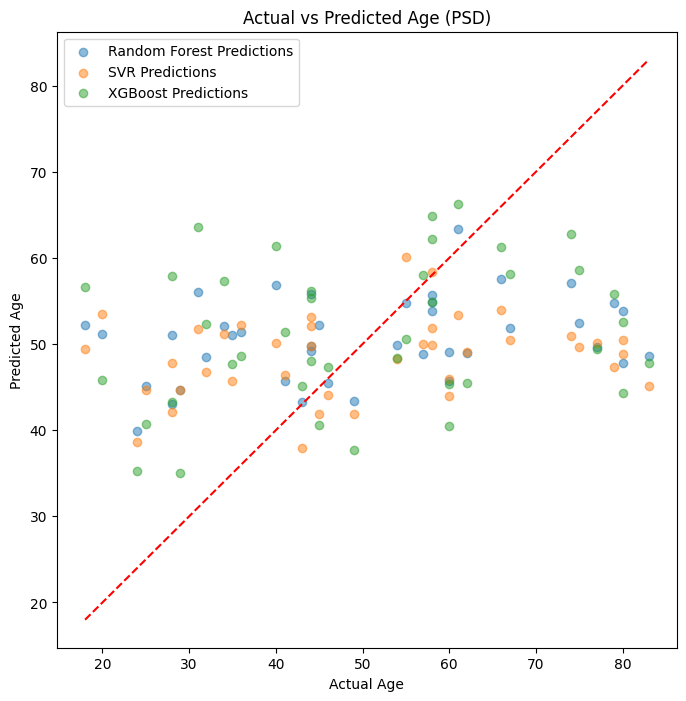

In [34]:
# Visualize the predictions against actual values for PSD
plt.figure(figsize=(8, 8))
plt.scatter(y_test_psd, y_pred_rf_psd, label='Random Forest Predictions', alpha=0.5)
plt.scatter(y_test_psd, y_pred_svr_psd, label='SVR Predictions', alpha=0.5)
plt.scatter(y_test_psd, y_pred_xgb_psd, label='XGBoost Predictions', alpha=0.5)
plt.plot([min(y_test_psd), max(y_test_psd)], [min(y_test_psd), max(y_test_psd)], color='red', linestyle='--')  # Line of perfect prediction
plt.xlabel("Actual Age")
plt.ylabel("Predicted Age")
plt.title("Actual vs Predicted Age (PSD)")
plt.legend()
plt.show()

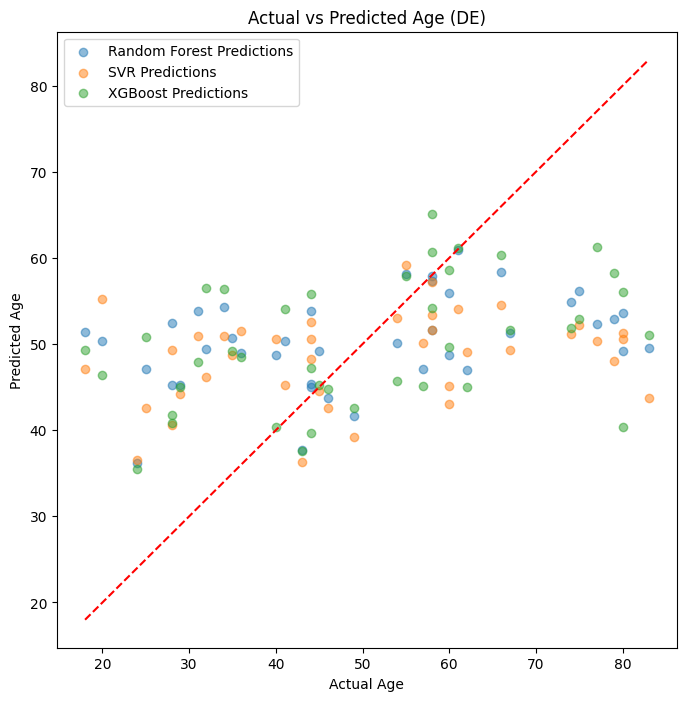

In [35]:
# Visualize the predictions against actual values for DE
plt.figure(figsize=(8, 8))
plt.scatter(y_test_de, y_pred_rf_de, label='Random Forest Predictions', alpha=0.5)
plt.scatter(y_test_de, y_pred_svr_de, label='SVR Predictions', alpha=0.5)
plt.scatter(y_test_de, y_pred_xgb_de, label='XGBoost Predictions', alpha=0.5)
plt.plot([min(y_test_de), max(y_test_de)], [min(y_test_de), max(y_test_de)], color='red', linestyle='--')  # Line of perfect prediction
plt.xlabel("Actual Age")
plt.ylabel("Predicted Age")
plt.title("Actual vs Predicted Age (DE)")
plt.legend()
plt.show()